In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

In [1]:
#new class containing everything for a convolutional network
import Mnist_net as mn

import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import importlib
importlib.reload(mn)

<module 'Mnist_net' from 'C:\\Users\\user\\Documents\\GitHub\\Saliency Comparison\\Mnist_net.py'>

In [4]:
#get the MNIST data from tensorflow 

data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [5]:
#structure is encoded for each layer as:
#[size of filters, number of filters, use biases, use pooling, use biases]
#the last two get converted to boolean from 1 or 0
#there is a fully connected layer added by default at the end of the network
structure =np.array([[200,0,1,1],[100,0,1,1],[50,0,1,1]])

In [6]:
#create a new instance of the network
net = mn.network()

#setup - load weights from previosly trained model
net.setup(load = "./Models/MLP",structure=structure,end_relu = True,end_biases = True, data = data)

INFO:tensorflow:Restoring parameters from ./Models/MLP


In [7]:
#an untrained model would be optimised here

#net.optimize(8000)

In [8]:
#the model can then be saved

#net.save("./Models/MLP")

Prediction is: 2


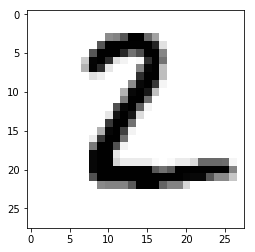

In [182]:
#test on an image from the test set
im=data.test.images[1]
prediction = net.give_class(im)

print("Prediction is: %d"%prediction)

net.plot_image(im)

In [183]:
net.give_prob(im)

array([[  1.97071698e-03,   3.36579804e-04,   9.85130191e-01,
          7.50293490e-03,   3.36579804e-04,   4.18928481e-04,
          3.29447258e-03,   3.36579804e-04,   3.36579833e-04,
          3.36579833e-04]], dtype=float32)

In [184]:
structure =np.array([[200,0,1,1],[100,0,1,1],[50,0,1,1]])

In [185]:
x = im.flatten()
w0 = net.session.run(net.weights[0])
b0 = net.session.run(net.biases[0])
y = x.dot(w0)+b0 #use biases
x0=y*(y>0) #use RElu

w1 = net.session.run(net.weights[1])
b1 = net.session.run(net.biases[1])
y = x0.dot(w1)+b1
x1=y*(y>0)

w2 = net.session.run(net.weights[2])
b2 = net.session.run(net.biases[2])
y = x1.dot(w2)+b2
x2=y*(y>0)

w3 = net.session.run(net.weights[3])
b3 = net.session.run(net.biases[3])
y = x2.dot(w3)+b3
x3=y*(y>0)

In [186]:
net.give_prob(im,3)

array([[ 1.76731753,  0.        ,  7.98169374,  3.10421395,  0.        ,
         0.2188651 ,  2.28116608,  0.        ,  0.        ,  0.        ]], dtype=float32)

In [187]:
x3

array([ 1.76731896, -0.        ,  7.98169136,  3.10421371, -0.        ,
        0.21886533,  2.28116584, -0.        , -0.        , -0.        ], dtype=float32)

In [188]:
#Main boundary constraint:
#why 7 not 9?
Prediction=np.argmax(net.give_prob(im,3)) #most popular
Comparison = net.give_prob(im,3).argsort()[0][-2:][0] #-2 is second most popular
#Comparison = 3
[Prediction,Comparison]

[2, 3]

In [189]:
constraints=[]
#backpropigate final layer
w0 = net.session.run(net.weights[0]).copy()
b0 = net.session.run(net.biases[0]).copy()

w1 = net.session.run(net.weights[1]).copy()
b1 = net.session.run(net.biases[1]).copy()

w2 = net.session.run(net.weights[2]).copy()
b2 = net.session.run(net.biases[2]).copy()

wt = net.session.run(net.weights[3]).copy()
bt = net.session.run(net.biases[3]).copy()

w3=(wt[:,Comparison]-wt[:,Prediction]).copy()
b3=(bt[Comparison]-bt[Prediction]).copy()

W=w0.dot(w1).dot(w2).dot(w3)
B=b0.dot(w1).dot(w2).dot(w3)+b1.dot(w2).dot(w3)+b2.dot(w3)+b3

#the final value needs comparison more likely than prediction
constraints.append([W,[B]])

#backpropigate layer 2 - each node must be positive
for node in range(0,b2.size):
    
    wt = w2.copy()
    bt = b2.copy()
    wt[:,node] = 0
    bt[node] = 0
        
    W=w0.dot(w1).dot(wt).dot(w3)
    B=b0.dot(w1).dot(wt).dot(w3)+b1.dot(wt).dot(w3)+bt.dot(w3)+b3
    constraints.append([W,[B]])

#backpropigate layer 1 - each node must be positive
for node in range(0,b1.size):
    wt = w1.copy()
    bt = b1.copy()
    wt[:,node] = 0
    bt[node] = 0
    
    W=w0.dot(wt).dot(w2).dot(w3)
    B=b0.dot(wt).dot(w2).dot(w3)+bt.dot(w2).dot(w3)+b2.dot(w3)+b3
    constraints.append([W,[B]])

#backpropigate layer 0 - each node must be positive
for node in range(0,b0.size):
    wt = w0.copy()
    bt = b0.copy()
    wt[:,node] = 0
    bt[node] = 0
    
    W=wt.dot(w1).dot(w2).dot(w3)
    B=bt.dot(w1).dot(w2).dot(w3)+b1.dot(w2).dot(w3)+b2.dot(w3)+b3
    constraints.append([W,[B]])

#backpropigate image 0 - each node must be positive
for node in range(0,im.size):
    wt = np.identity(im.size)
    wt[:,node] = 0
    
    W=wt.dot(w0).dot(w1).dot(w2).dot(w3)
    B=b0.dot(w1).dot(w2).dot(w3)+b1.dot(w2).dot(w3)+b2.dot(w3)+b3
    constraints.append([W,[B]])

    #also must be less than 1    
for node in range(0,im.size):
    wt = np.identity(im.size)
    bt = np.zeros(im.size)
    wt[:,node] = 0
    bt[node] = 1
    
    W=wt.dot(w0).dot(w1).dot(w2).dot(w3)
    B=bt.dot(w0).dot(w1).dot(w2).dot(w3)+b0.dot(w1).dot(w2).dot(w3)+b1.dot(w2).dot(w3)+b2.dot(w3)+b3
    constraints.append([W,[B]])
    
    
#normalize

for constraint in range(0,len(constraints)):
    norm = np.linalg.norm(constraints[constraint][0])
    constraints[constraint][1] = constraints[constraint][1]/norm
    constraints[constraint][0] = constraints[constraint][0]/norm
    
    

26


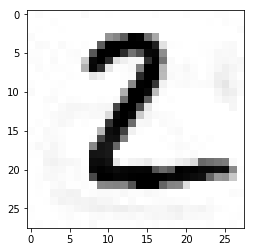

0


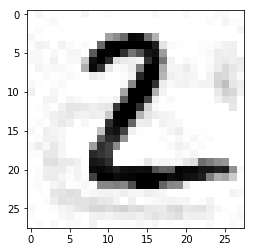

1214


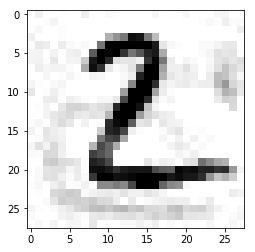

1918


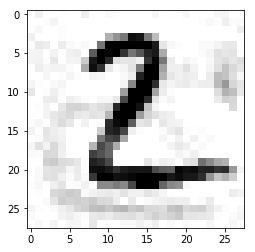

In [203]:
#find point to hyperplane distances - only interested in the negative ones
#so keep track of the constraints we still need seperatly
point = im.flatten().copy()
self_dists =np.array([])
crit_dists =np.array([])
dead_constraints = []

n0 = constraints[0][0]

for constraint in range(0,len(constraints)):
    
    W=constraints[constraint][0]
    B=constraints[constraint][1]
    
    self_dist = (-B-point.dot(W))/W.dot(W)
    crit_dist = self_dist

    self_dists=np.append(self_dists,self_dist[0])
    crit_dists=np.append(crit_dists,crit_dist[0])
                
Found = False

while Found==False:
    #find the closest edge
    constraint_met = True
    check_constraint = 0
    while constraint_met==True:
        if check_constraint==len(constraints):
            Found = True
            constraint_met = False
        else:
            constraint = crit_dists.argsort()[check_constraint]
            if constraint not in dead_constraints:
                if point.dot(constraints[constraint][0])+constraints[constraint][1]>0:
                    check_constraint = check_constraint+1
                else:
                    constraint_met = False
            else:
                
                check_constraint = check_constraint+1
    print(constraint)
    if Found==False:
        W=constraints[constraint][0].copy()
        B=constraints[constraint][1].copy()
        point = point + crit_dists[constraint]*W
        #dead_constraints.append(constraint)
        crit_dists =np.array([])
        
        for constraint in range(0,len(constraints)):
            W=constraints[constraint][0]
            B=constraints[constraint][1]
            crit_dist = (-B-point.dot(W))/W.dot(W)
            crit_dists=np.append(crit_dists,self_dist[0]) 
    
    point = point*(point>0)
    point = np.add(point,-1)
    point = point*(point<0)
    point = np.add(point,1)
    net.plot_image(point)

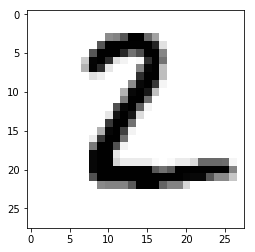

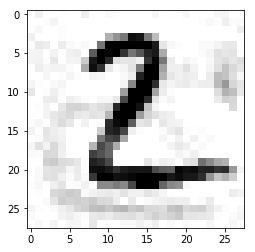

In [204]:
net.plot_image(im)
net.plot_image(point)

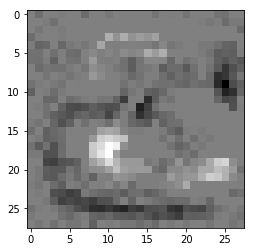

In [205]:
net.plot_image(point-im)

In [206]:
point.dot(constraints[0][0])+constraints[0][1]

array([ 0.76603043], dtype=float32)

In [207]:
net.give_prob(point)[0]

array([  1.43725588e-03,   5.01476752e-04,   9.90497693e-03,
         9.66028810e-01,   5.01476752e-04,   1.96198616e-02,
         5.01476752e-04,   5.01476752e-04,   5.01476752e-04,
         5.01476752e-04], dtype=float32)

In [215]:
#root sum of squared differences
#i.e the euclidian distance to point from im.
#the maximum is 784 from all whit to all black
(np.sum((point-im).dot(point-im)))**0.5

2.4316591847215099

In [216]:
np.sum(np.abs(point-im))

40.826812869650524